In [22]:
import os

EVT_REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) 
MODEL_DIR = os.path.join(EVT_REPO_ROOT, "pretrained_models", "DVS128_11_24ms_dwn") 
DATA_DIR = os.path.join(EVT_REPO_ROOT, "datasets", "DvsGesture") 


print("EVT_REPO_ROOT:", EVT_REPO_ROOT) 
print("DATA_DIR:", DATA_DIR) 
print("MODEL_DIR:", MODEL_DIR)

EVT_REPO_ROOT: /home/azureuser/TESE/dev/EvT-OG
DATA_DIR: /home/azureuser/TESE/dev/EvT-OG/datasets/DvsGesture
MODEL_DIR: /home/azureuser/TESE/dev/EvT-OG/pretrained_models/DVS128_11_24ms_dwn


In [23]:
# Cell 1
import sys
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

if EVT_REPO_ROOT not in sys.path:
    sys.path.insert(0, EVT_REPO_ROOT)

from data_generation import Event_DataModule
import evaluation_utils
from trainer import EvNetModel

device = torch.device('cpu')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [24]:
# Cell 2
all_params = json.load(open(f"{MODEL_DIR}/all_params.json", 'r'))
path_weights = evaluation_utils.get_best_weigths(MODEL_DIR, 'val_acc', 'max')
model = EvNetModel.load_from_checkpoint(path_weights, map_location='cpu', **all_params).eval().to(device)

data_params = dict(all_params.get('data_params', {}))
data_params['batch_size'] = 1
data_params['pin_memory'] = False
data_params['sample_repetitions'] = 1
data_params['workers'] = 2
dm = Event_DataModule(**data_params)
if DATA_DIR is not None:
    dataset_name = data_params.get('dataset_name', getattr(dm, 'dataset_name', None))
    suffix_map = {
        'DVS128': 'clean_dataset_frames_12000',
        'ASL_DVS': 'clean_dataset_frames_2000',
        'Caltech': 'clean_dataset_frames_2000',
        'SLAnimals_3s': 'dataset_3sets_12000',
        'SLAnimals_4s': 'dataset_4sets_12000',
    }
    candidates = []
    candidates.append(DATA_DIR)
    if dataset_name in suffix_map:
        candidates.append(os.path.join(DATA_DIR, suffix_map[dataset_name]))
    if dataset_name == 'DVS128':
        candidates.append(os.path.join(EVT_REPO_ROOT, 'datasets', 'DvsGesture', 'clean_dataset_frames_12000'))
    if dataset_name == 'ASL_DVS':
        candidates.append(os.path.join(EVT_REPO_ROOT, 'datasets', 'ICCV2019_DVS_dataset', 'clean_dataset_frames_2000'))
    if dataset_name == 'Caltech':
        candidates.append(os.path.join(EVT_REPO_ROOT, 'datasets', 'N_Caltech_101', 'clean_dataset_frames_2000'))
    if dataset_name == 'SLAnimals_3s':
        candidates.append(os.path.join(EVT_REPO_ROOT, 'datasets', 'SL_animal_splits', 'dataset_3sets_12000'))
    if dataset_name == 'SLAnimals_4s':
        candidates.append(os.path.join(EVT_REPO_ROOT, 'datasets', 'SL_animal_splits', 'dataset_4sets_12000'))
    data_folder = None
    for cand in candidates:
        if cand is None:
            continue
        if os.path.isdir(os.path.join(cand, 'train')) and os.path.isdir(os.path.join(cand, 'test')):
            data_folder = cand
            break
    if data_folder is None:
        data_folder = DATA_DIR
    if not data_folder.endswith('/'):
        data_folder = data_folder + '/'
    dm.data_folder = data_folder
    print('Using data_folder:', dm.data_folder)
dl = dm.val_dataloader()

batch = None
for batch in dl:
    if batch is None:
        continue
    polarity, pixels, labels = batch
    if polarity is None:
        continue
    break

print('polarity shape:', None if polarity is None else tuple(polarity.shape))
print('pixels shape:', None if pixels is None else tuple(pixels.shape))
print('labels shape:', None if labels is None else tuple(labels.shape))

# Infer H/W from params or pixels; fall back to DVS128.
height = data_params.get('height', data_params.get('sensor_height', getattr(dm, 'height', None)))
width = data_params.get('width', data_params.get('sensor_width', getattr(dm, 'width', None)))
if (height is None or width is None) and pixels is not None and pixels.numel() > 0:
    pix_any = pixels
    if pix_any.dim() >= 4:
        pix_any = pix_any[0, 0]
    elif pix_any.dim() == 3:
        pix_any = pix_any[0]
    if pix_any.numel() > 0:
        width = int(pix_any[:, 0].max().item()) + 1
        height = int(pix_any[:, 1].max().item()) + 1
if height is None or width is None:
    height, width = 128, 128


def _box_blur(img, k=3):
    if k <= 1:
        return img
    pad = k // 2
    padded = np.pad(img, ((pad, pad), (pad, pad)), mode='edge')
    out = np.zeros_like(img)
    for dy in range(k):
        for dx in range(k):
            out += padded[dy:dy + img.shape[0], dx:dx + img.shape[1]]
    return out / float(k * k)


def render_dense_event(img, clip_percentile=99.7, gamma=0.55, cmap_name='viridis', blur_k=3, log1p=True):
    """
    img: 2D float array (dense accumulation)
    Produz RGB (H,W,3) já com colormap.
    """
    if img is None:
        return np.zeros((height, width, 3), dtype=np.float32)

    x = img.astype(np.float32)

    # optional: compress dynamic range so weak motion becomes visible
    if log1p:
        x = np.log1p(np.maximum(x, 0.0))

    # simple blur to make hand shape continuous (no scipy needed)
    if blur_k and blur_k > 1:
        x = _box_blur(x, k=blur_k)

    # robust normalization
    if np.any(x > 0):
        hi = np.percentile(x[x > 0], clip_percentile)
    else:
        hi = np.percentile(x, clip_percentile)

    hi = float(hi) if hi > 1e-8 else float(max(x.max(), 1.0))
    x = np.clip(x / hi, 0.0, 1.0)

    # gamma < 1 boosts faint structures
    x = np.power(x, gamma)

    cm = plt.get_cmap(cmap_name)
    return cm(x)[..., :3]


def to_frame_sequence(pols, pixs, height, width,
                      persistence=0.6,          # <- add temporal persistence
                      clip_percentile=99.7,
                      gamma=0.55,
                      cmap_name='viridis',
                      blur_k=3,
                      log1p=True):
    """
    Build user-friendly dense frames from sparse (polarity, pixels).
    IMPORTANT: accumulates events per pixel (does NOT overwrite).
    """
    frames = []
    if pols is None or pixs is None:
        return frames

    pols_t = pols
    pixs_t = pixs

    if pols_t.dim() == 3:
        pols_t = pols_t.unsqueeze(1)
    if pixs_t.dim() == 3:
        pixs_t = pixs_t.unsqueeze(1)

    if pols_t.dim() < 3 or pixs_t.dim() < 3:
        return frames

    prev_dense = None
    T = pols_t.shape[0]

    for t in range(T):
        pol_t = pols_t[t, 0]   # [N, C] or [N]
        pix_t = pixs_t[t, 0]   # [N, 2]

        if pix_t.numel() == 0:
            dense = np.zeros((height, width), dtype=np.float32)
        else:
            if pol_t.dim() == 1:
                intens = pol_t.float()
            else:
                intens = pol_t.float().sum(-1)

            xs = pix_t[:, 0].long().clamp(0, width - 1)
            ys = pix_t[:, 1].long().clamp(0, height - 1)

            dense = np.zeros((height, width), dtype=np.float32)

            # ACCUMULATE (scatter-add)
            xs_np = xs.cpu().numpy()
            ys_np = ys.cpu().numpy()
            val_np = intens.detach().cpu().numpy()

            # add-at accumulates repeated indices instead of overwriting
            np.add.at(dense, (ys_np, xs_np), np.abs(val_np))

        if prev_dense is not None and persistence and persistence > 0:
            dense = dense + persistence * prev_dense
        prev_dense = dense

        frames.append(render_dense_event(
            dense,
            clip_percentile=clip_percentile,
            gamma=gamma,
            cmap_name=cmap_name,
            blur_k=blur_k,
            log1p=log1p
        ))

    return frames

# DVS128-style look: no persistence, high-percentile clip, linear gamma.
frames = to_frame_sequence(
    polarity, pixels, height, width,
    persistence=0.6,
    clip_percentile=99.7,
    gamma=0.55,
    cmap_name="viridis",
    blur_k=3,
    log1p=True
)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames[0] if frames else np.zeros((height, width, 3)))
ax.set_axis_off()

def update(i):
    im.set_data(frames[i])
    ax.set_title(f't={i}')
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())


Using data_folder: /home/azureuser/TESE/dev/EvT-OG/datasets/DvsGesture/clean_dataset_frames_12000/
polarity shape: (20, 1, 69, 144)
pixels shape: (20, 1, 69, 2)
labels shape: (1,)


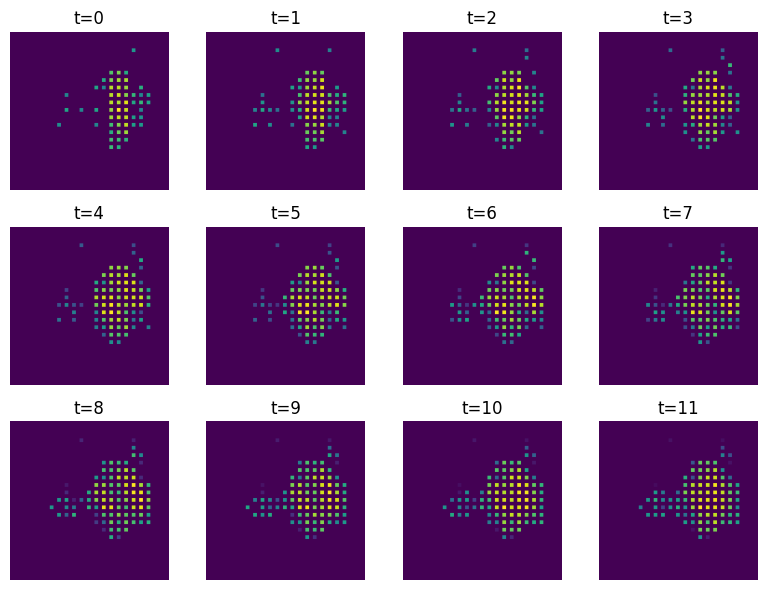

In [25]:
# Cell 3
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    if i < len(frames):
        ax.imshow(frames[i])
    else:
        ax.imshow(np.zeros((height, width, 3)))
    ax.set_title(f't={i}')
    ax.set_axis_off()
plt.tight_layout()

pol_ts shape: (69, 144)
pix_ts shape: (69, 2)
nonzero patches: 54


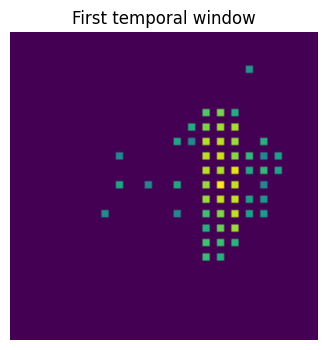

In [26]:
# Cell 4
ts = 0
pol_ts = polarity[ts]
pix_ts = pixels[ts]
if pol_ts.dim() == 3:
    pol_ts = pol_ts[0]
if pix_ts.dim() == 3:
    pix_ts = pix_ts[0]
print('pol_ts shape:', tuple(pol_ts.shape))
print('pix_ts shape:', tuple(pix_ts.shape))
nonzero = (pol_ts.sum(-1) != 0).sum().item() if pol_ts.numel() > 0 else 0
print('nonzero patches:', nonzero)

frame_ts = to_frame_sequence(polarity[ts:ts+1], pixels[ts:ts+1], height, width)[0]
plt.figure(figsize=(4, 4))
plt.imshow(frame_ts)
plt.title('First temporal window')
plt.axis('off')
plt.show()



sum abs: 1051.340087890625
nonzero pixels: 54


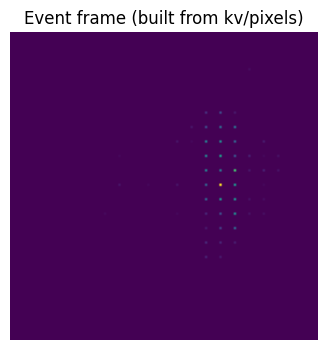

In [27]:
# Cell 5
pol_ts = polarity[0]
pix_ts = pixels[0]
if pol_ts.dim() == 3:
    pol_ts = pol_ts[0]
if pix_ts.dim() == 3:
    pix_ts = pix_ts[0]
if pol_ts.dim() == 1:
    pol_ts = pol_ts.unsqueeze(-1)
intens = pol_ts.sum(-1)
frame_built = torch.zeros((height, width), dtype=intens.dtype)
if pix_ts.numel() > 0:
    xs = pix_ts[:, 0].long().clamp(0, width - 1)
    ys = pix_ts[:, 1].long().clamp(0, height - 1)
    frame_built[ys, xs] = intens

print('sum abs:', frame_built.abs().sum().item())
print('nonzero pixels:', (frame_built != 0).sum().item())

plt.figure(figsize=(4, 4))
plt.imshow(render_dense_event(frame_built.cpu().numpy(), clip_percentile=99.9, gamma=1.0, cmap_name='viridis', blur_k=0, log1p=False))
plt.title('Event frame (built from kv/pixels)')
plt.axis('off')
plt.show()



activated patches: 54


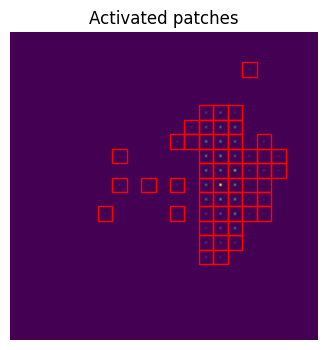

Accuracy: 100.00%


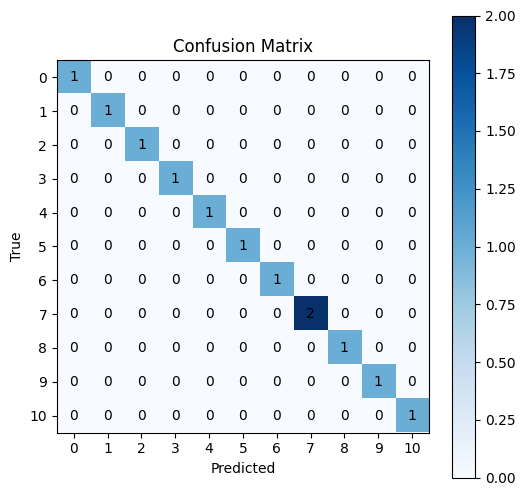

In [28]:
# Cell 6
import matplotlib.patches as patches

ts = 0
pol_slice = polarity[ts:ts+1]
if pol_slice.dim() == 3:
    pol_slice = pol_slice.unsqueeze(1)
if pol_slice.dim() >= 3:
    patch_dim = pol_slice.dim() - 2
    reduce_dims = [d for d in range(pol_slice.dim()) if d != patch_dim]
    mask = pol_slice.sum(dim=reduce_dims) != 0
else:
    mask = pol_slice != 0

pol_ts = polarity[ts]
pix_ts = pixels[ts]
if pol_ts.dim() == 3:
    pol_ts = pol_ts[0]
if pix_ts.dim() == 3:
    pix_ts = pix_ts[0]

num_active = int(mask.sum().item()) if torch.is_tensor(mask) else int(mask)
print('activated patches:', num_active)

patch_size = all_params.get('model_params', {}).get('patch_size', data_params.get('patch_size', 6))
if isinstance(patch_size, (list, tuple)):
    patch_size = patch_size[0]
patch_size = int(patch_size)

base_frame = frame_built.cpu().numpy()
base_frame = render_dense_event(base_frame, clip_percentile=99.9, gamma=1.0, cmap_name='viridis', blur_k=0, log1p=False)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(base_frame)

if pix_ts.numel() > 0:
    flat_mask = mask.flatten().tolist() if torch.is_tensor(mask) else list(mask)
    for i, active in enumerate(flat_mask):
        if not active or i >= pix_ts.shape[0]:
            continue
        x, y = pix_ts[i].tolist()
        rect = patches.Rectangle((x - patch_size // 2, y - patch_size // 2),
                                 patch_size, patch_size,
                                 linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
ax.set_title('Activated patches')
ax.set_axis_off()
plt.show()

# Confusion matrix + accuracy
num_classes = all_params.get('clf_params', {}).get('opt_classes', getattr(dm, 'num_classes', 11))
cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in dm.val_dataloader():
        if batch is None:
            continue
        pols, pixs, labels = batch
        if pols is None:
            continue
        pols = pols.to(device)
        pixs = pixs.to(device)
        logits = model(pols, pixs)[1]
        preds = logits.argmax(dim=-1).cpu()
        labels = labels.cpu()
        for t, p in zip(labels, preds):
            y_true.append(int(t.item()))
            y_pred.append(int(p.item()))
            cm[t, p] += 1

correct = sum(int(t == p) for t, p in zip(y_true, y_pred))
acc = 100.0 * correct / max(1, len(y_true))
print(f'Accuracy: {acc:.2f}%')

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm.numpy(), cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, int(cm[i, j].item()), ha='center', va='center', color='black')

ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
plt.title('Confusion Matrix')
plt.colorbar(im, ax=ax)
plt.show()

